In [18]:
from datetime import datetime
from pointcloud import PointCloud
from scipy import spatial, stats
import numpy as np
import time
import csv
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def log(text):
    logtime = datetime.now().strftime("%H:%M:%S.%f")[:-3]
    print("[{}] {}".format(logtime, text))


In [3]:
def matching(pcfix, pcmov):
    kdtree = spatial.cKDTree(np.column_stack((pcmov.x, pcmov.y, pcmov.z)))
    query_points = np.column_stack((pcfix.x[pcfix.sel], pcfix.y[pcfix.sel], pcfix.z[pcfix.sel]))
    _, pcmov.sel = kdtree.query(query_points, k=1, p=2, n_jobs=-1)

    dx = pcmov.x[pcmov.sel] - pcfix.x[pcfix.sel]
    dy = pcmov.y[pcmov.sel] - pcfix.y[pcfix.sel]
    dz = pcmov.z[pcmov.sel] - pcfix.z[pcfix.sel]

    nx = pcfix.nx[pcfix.sel]
    ny = pcfix.ny[pcfix.sel]
    nz = pcfix.nz[pcfix.sel]

    no_correspondences = len(pcfix.sel)
    distances = np.empty(no_correspondences)
    for i in range(0, no_correspondences):
        distances[i] = dx[i]*nx[i] + dy[i]*ny[i] + dz[i]*nz[i]

    return distances


def reject(pcfix, pcmov, min_planarity, distances):

    planarity = pcfix.planarity[pcfix.sel]

    med = np.median(distances)
    sigmad = stats.median_absolute_deviation(distances)

    keep_distance = [abs(d-med) <= 3*sigmad for d in distances]
    keep_planarity = [p > min_planarity for p in planarity]

    keep = keep_distance and keep_planarity

    pcfix.sel = pcfix.sel[keep]
    pcmov.sel = pcmov.sel[keep]
    distances = distances[keep]

    return distances

In [5]:
def estimate_rigid_body_transformation(x_fix, y_fix, z_fix, nx_fix, ny_fix, nz_fix,
                                       x_mov, y_mov, z_mov):

    A = np.column_stack((-z_mov*ny_fix + y_mov*nz_fix,
                          z_mov*nx_fix - x_mov*nz_fix,
                         -y_mov*nx_fix + x_mov*ny_fix,
                         nx_fix,
                         ny_fix,
                         nz_fix))

    l = nx_fix*(x_fix-x_mov) + ny_fix*(y_fix-y_mov) + nz_fix*(z_fix-z_mov)

    x, _, _, _ = np.linalg.lstsq(A, l)

    residuals = A @ x - l

    R = euler_angles_to_linearized_rotation_matrix(x[0], x[1], x[2])

    t = x[3:6]

    H = create_homogeneous_transformation_matrix(R, t)

    return H, residuals


def euler_angles_to_linearized_rotation_matrix(alpha1, alpha2, alpha3):

    dR = np.array([[      1, -alpha3,  alpha2],
                   [ alpha3,       1, -alpha1],
                   [-alpha2,  alpha1,       1]])

    return dR


def create_homogeneous_transformation_matrix(R, t):

    H = np.array([[R[0,0], R[0,1], R[0,2], t[0]],
                  [R[1,0], R[1,1], R[1,2], t[1]],
                  [R[2,0], R[2,1], R[2,2], t[2]],
                  [     0,      0,      0,    1]])

    return H



In [6]:
def check_convergence_criteria(distances_new, distances_old, min_change):

    def change(new, old):
        return np.abs((new-old)/old*100)

    change_of_mean = change(np.mean(distances_new), np.mean(distances_old))
    change_of_std = change(np.std(distances_new), np.std(distances_old))

    return True if change_of_mean < min_change and change_of_std < min_change else False

def simpleicp(X_fix, X_mov, correspondences=1000, neighbors=10, min_planarity=0.3, min_change=1,
              max_iterations=100):

    start_time = time.time()
    log("Create point cloud objects ...")
    pcfix = PointCloud(X_fix[:,0], X_fix[:,1], X_fix[:,2])
    pcmov = PointCloud(X_mov[:,0], X_mov[:,1], X_mov[:,2])

    log("Select points for correspondences in fixed point cloud ...")
    pcfix.select_n_points(correspondences)
    sel_orig = pcfix.sel

    log("Estimate normals of selected points ...")
    pcfix.estimate_normals(neighbors)

    H = np.eye(4)
    residual_distances = []

    log("Start iterations ...")
    for i in range(0, max_iterations):

        initial_distances = matching(pcfix, pcmov)

        # Todo Change initial_distances without return argument
        initial_distances = reject(pcfix, pcmov, min_planarity, initial_distances)

        dH, residuals = estimate_rigid_body_transformation(
            pcfix.x[pcfix.sel], pcfix.y[pcfix.sel], pcfix.z[pcfix.sel],
            pcfix.nx[pcfix.sel], pcfix.ny[pcfix.sel], pcfix.nz[pcfix.sel],
            pcmov.x[pcmov.sel], pcmov.y[pcmov.sel], pcmov.z[pcmov.sel])

        residual_distances.append(residuals)

        pcmov.transform(dH)

        H = dH @ H
        pcfix.sel = sel_orig

        if i > 0:
            if check_convergence_criteria(residual_distances[i], residual_distances[i-1],
                                          min_change):
                log("Convergence criteria fulfilled -> stop iteration!")
                break

        if i == 0:
            log("{:9s} | {:15s} | {:15s} | {:15s}".format("Iteration", "correspondences",
                                                          "mean(residuals)", "std(residuals)"))
            log("{:9d} | {:15d} | {:15.4f} | {:15.4f}".format(0, len(initial_distances),
                                                              np.mean(initial_distances),
                                                              np.std(initial_distances)))
        log("{:9d} | {:15d} | {:15.4f} | {:15.4f}".format(i+1, len(residual_distances[i]),
                                                          np.mean(residual_distances[i]),
                                                          np.std(residual_distances[i])))

    log("Estimated transformation matrix H:")
    log("H = [{:12.6f} {:12.6f} {:12.6f} {:12.6f}]".format(H[0,0], H[0,1], H[0,2], H[0,3]))
    log("    [{:12.6f} {:12.6f} {:12.6f} {:12.6f}]".format(H[1,0], H[1,1], H[1,2], H[1,3]))
    log("    [{:12.6f} {:12.6f} {:12.6f} {:12.6f}]".format(H[2,0], H[2,1], H[2,2], H[2,3]))
    log("    [{:12.6f} {:12.6f} {:12.6f} {:12.6f}]".format(H[3,0], H[3,1], H[3,2], H[3,3]))
    log("Finished in {:.3f} seconds!".format(time.time()-start_time))

    return H

In [11]:
def read_xyz(path_to_pc):
    X = []
    with open(path_to_pc) as f:
        reader = csv.reader(f, delimiter=' ')
        for row in reader:
            X.append(list(map(float, row)))
    return X

In [15]:
path_to_pc1 = 'dragon1.xyz'
X_fix = np.array(read_xyz(path_to_pc1))

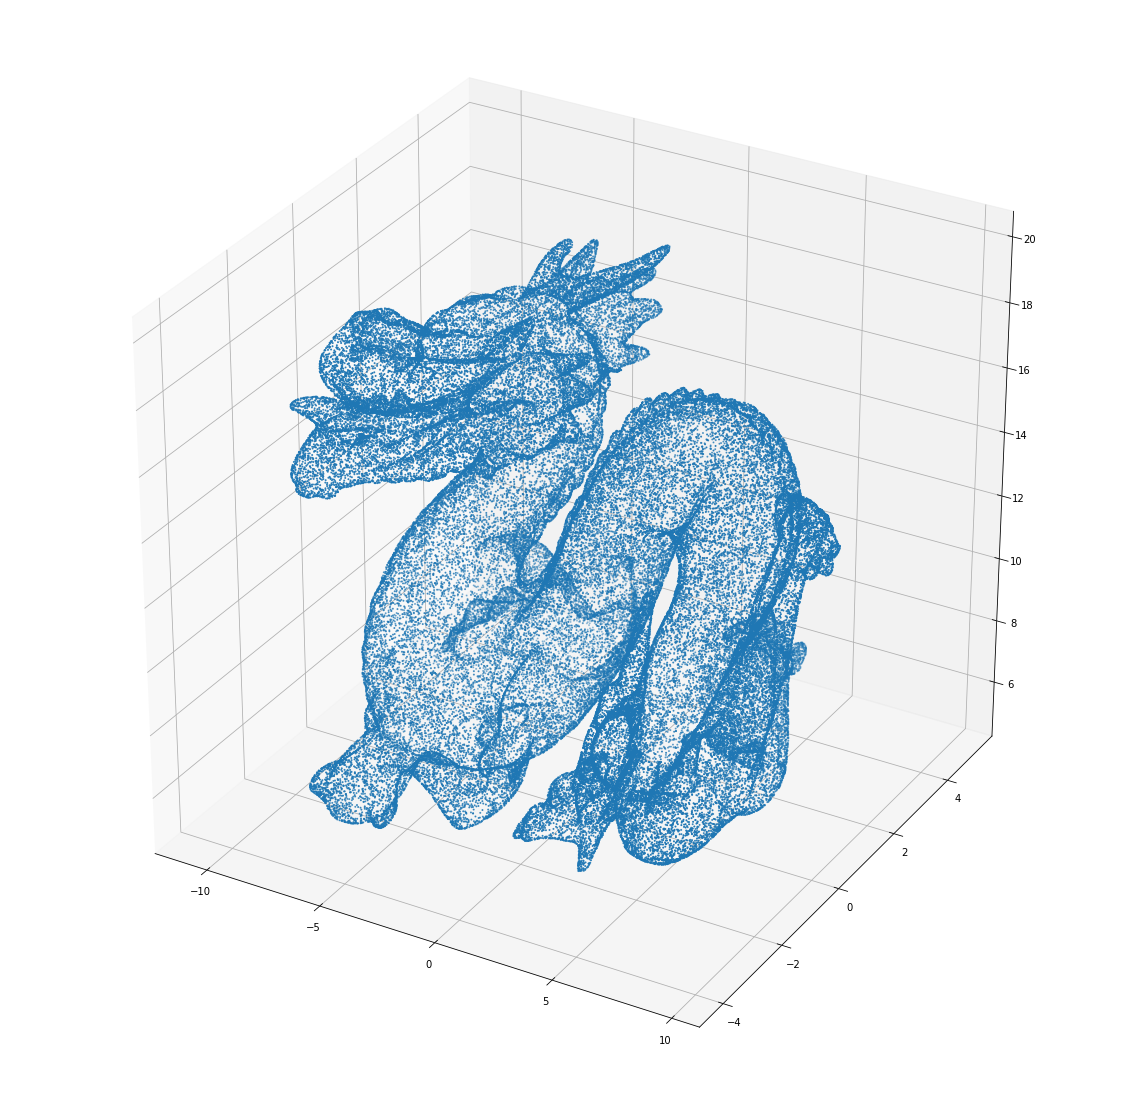

In [29]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(projection='3d')
ax.scatter(X_fix[:,0], X_fix[:,1], X_fix[:,2], marker="o",s=1)

In [30]:
len(X_fix)

100000